In [18]:
import pandas as pd

file_path = 'C:/Users/20101/Desktop/stocks/AAPL.csv'
data = pd.read_csv(file_path)

# Display the first few rows to verify that the file is loaded correctly
print(data.head())


         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086999  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600


In [19]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select only the 'Close' column for prediction
close_data = data[['Close']]
print(close_data.head())


               Close
Date                
1980-12-12  0.128348
1980-12-15  0.121652
1980-12-16  0.112723
1980-12-17  0.115513
1980-12-18  0.118862


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

print(scaled_data[:5])  # Display the first few scaled values


[[0.00040008]
 [0.00036628]
 [0.00032119]
 [0.00033528]
 [0.00035219]]


In [21]:
# Creating the dataset for LSTM
import numpy as np

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)


In [22]:
# Splitting the data into training and testing sets
training_size = int(len(X) * 0.8)
test_size = len(X) - training_size

X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [23]:
# Building the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()  # Printing the model summary


C:\Users\20101\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


8722/8722 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 7.2483e-05


In [25]:
# Evaluating the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

import numpy as np
rmse = np.sqrt(np.mean(((predictions - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2)))
print(f'Root Mean Squared Error: {rmse}')


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Root Mean Squared Error: 9.219363307114802


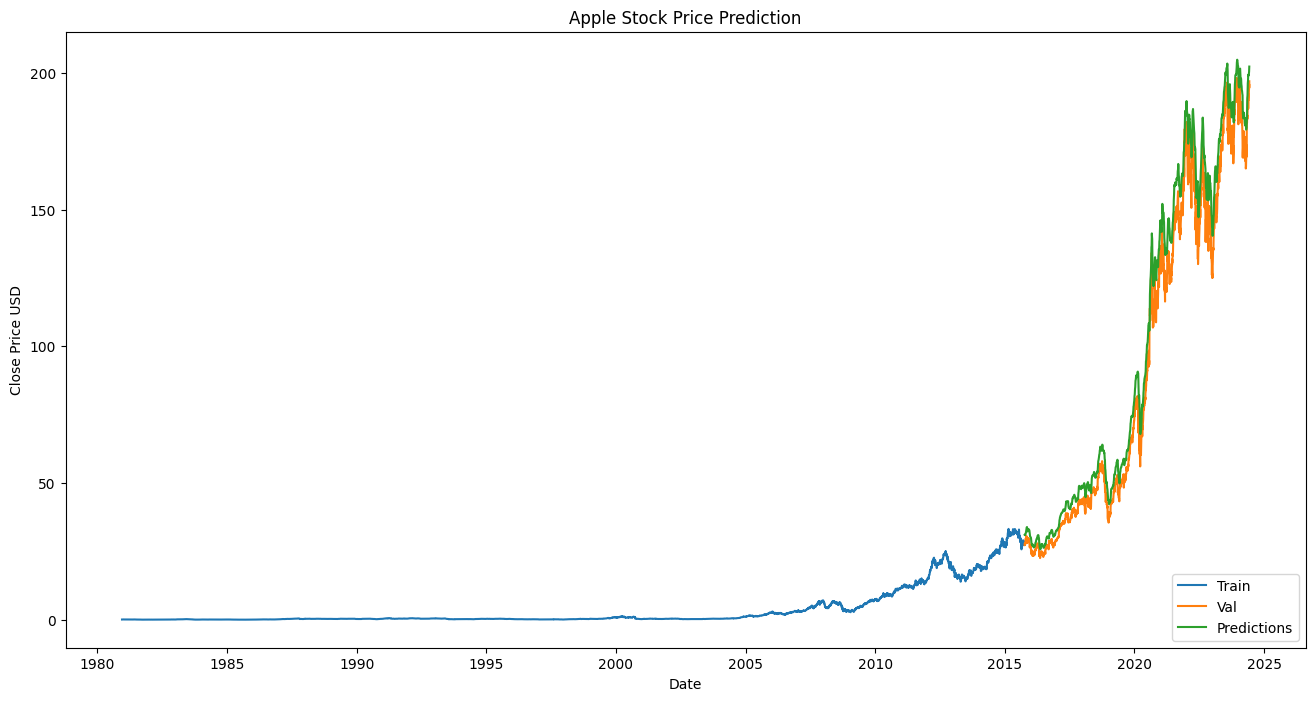

In [26]:
# Visualizing the results
valid_data = close_data[training_size + time_step:]
valid_data = valid_data[:-1]
valid_data['Predictions'] = predictions

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
